In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Select kaggle.json file from your local machine

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chandsafi","key":"085367382313c9c4d592bc8f98d6f618"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!

In [5]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 90% 108M/121M [00:00<00:00, 143MB/s] 
100% 121M/121M [00:01<00:00, 126MB/s]


In [7]:
!unzip face-expression-recognition-dataset.zip -d /content/face-expression-recognition-dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/8797.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/8818.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/886.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9037.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9040.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9101.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/911.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9179.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9205.jpg  
  inflating: /content/face-expression-recognition-dataset/images/validation/fear/9232.jpg  
  inflating: /content/face-expr

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

# Change the import statement to use tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training and validation sets with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    shear_range=0.2,              # Random shear
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Flip images
    validation_split=0.2          # Reserve a portion for validation
)

# Training data generator
train_generator = datagen.flow_from_directory(
    '/content/face-expression-recognition-dataset/images/train',  # Path to your dataset
    target_size=(64, 64),          # Resize images to 64x64
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    '/content/face-expression-recognition-dataset/images/validation',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 23060 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.


In [24]:


import pandas as pd
import os


def generate_csv_from_directory(directory):
    """Generates a CSV file containing image paths and labels from a directory structure."""

    data = []
    for expression in os.listdir(directory):
        expression_dir = os.path.join(directory, expression)
        if os.path.isdir(expression_dir):
            for image_file in os.listdir(expression_dir):
                image_path = os.path.join(expression_dir, image_file)
                data.append({'image_path': image_path, 'label': expression})
    df = pd.DataFrame(data)
    return df

# Example usage (replace with your actual directory path)
train_directory = '/content/face-expression-recognition-dataset/images/train'
train_df = generate_csv_from_directory(train_directory)
train_df.to_csv('train_data.csv', index=False)



In [25]:
import pandas as pd

# Assuming the CSV file 'train_data.csv' has been created as in the previous code
train_df = pd.read_csv('train_data.csv')
train_df

,image_path,label
0,/content/face-expression-recognition-dataset/i...,happy
1,/content/face-expression-recognition-dataset/i...,happy
2,/content/face-expression-recognition-dataset/i...,happy
3,/content/face-expression-recognition-dataset/i...,happy
4,/content/face-expression-recognition-dataset/i...,happy
...,...,...
28816,/content/face-expression-recognition-dataset/i...,angry
28817,/content/face-expression-recognition-dataset/i...,angry
28818,/content/face-expression-recognition-dataset/i...,angry
28819,/content/face-expression-recognition-dataset/i...,angry


In [26]:

validation_directory = '/content/face-expression-recognition-dataset/images/validation'
validation_df = generate_csv_from_directory(validation_directory)
validation_df.to_csv('validation_data.csv', index=False)

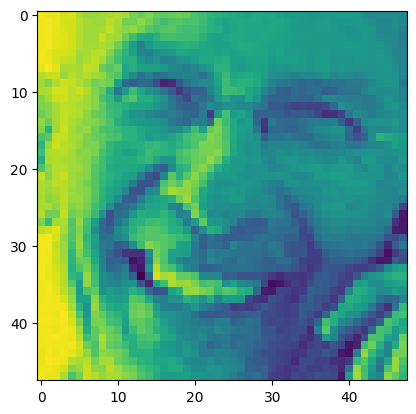

In [27]:
# prompt: how i can see the first image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming 'train_data.csv' exists and contains the image paths
train_df = pd.read_csv('train_data.csv')

# Get the path of the first image
first_image_path = train_df['image_path'].iloc[0]

# Display the first image
img = mpimg.imread(first_image_path)
imgplot = plt.imshow(img)
plt.show()

In [14]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2


# Load MobileNetV2 with pre-trained weights and exclude the top layers
mobilenetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build a simple CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 classes for 7 expressions



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [17]:
# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


721/721 ━━━━━━━━━━━━━━━━━━━━ 177s 242ms/step - accuracy: 0.2980 - loss: 1.7532 - val_accuracy: 0.3770 - val_loss: 1.6234
Epoch 2/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 173s 239ms/step - accuracy: 0.4128 - loss: 1.5280 - val_accuracy: 0.4302 - val_loss: 1.4753
Epoch 3/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 172s 238ms/step - accuracy: 0.4395 - loss: 1.4501 - val_accuracy: 0.4323 - val_loss: 1.4508
Epoch 4/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 202s 238ms/step - accuracy: 0.4716 - loss: 1.3805 - val_accuracy: 0.4522 - val_loss: 1.4007
Epoch 5/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 205s 243ms/step - accuracy: 0.4874 - loss: 1.3394 - val_accuracy: 0.4670 - val_loss: 1.3829
Epoch 6/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 174s 241ms/step - accuracy: 0.5012 - loss: 1.2970 - val_accuracy: 0.4571 - val_loss: 1.3623
Epoch 7/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 171s 237ms/step - accuracy: 0.5068 - loss: 1.2749 - val_accuracy: 0.4741 - val_loss: 1.3828
Epoch 8/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 169s 234ms/step - accuracy: 0.5312 - loss: 1.22

In [18]:
# prompt: code to save the model

# Save the model
model.save('my_model.h5')

# Download the model file
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# prompt: what would be next line of code for the above processing code after training

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy:', accuracy)

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.5179 - loss: 1.4122
Validation accuracy: 0.5017718076705933


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step


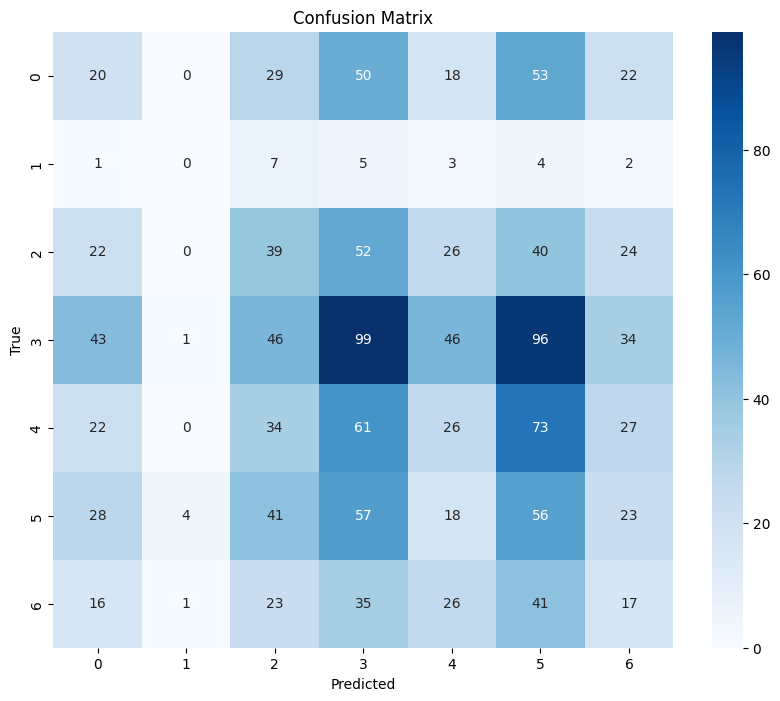

In [53]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the validation set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
Y_true = validation_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(Y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.5120 - loss: 1.4796
Validation accuracy: 0.5024805068969727


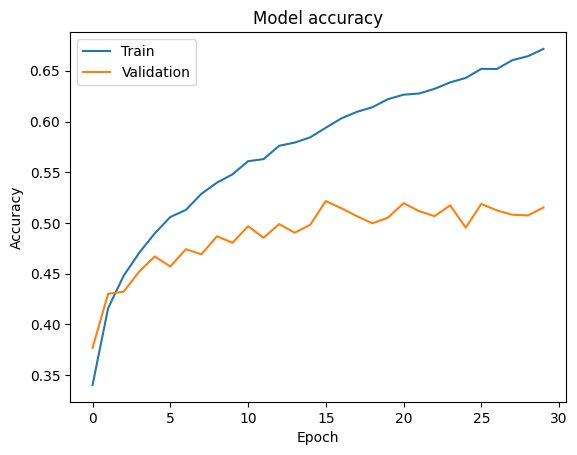

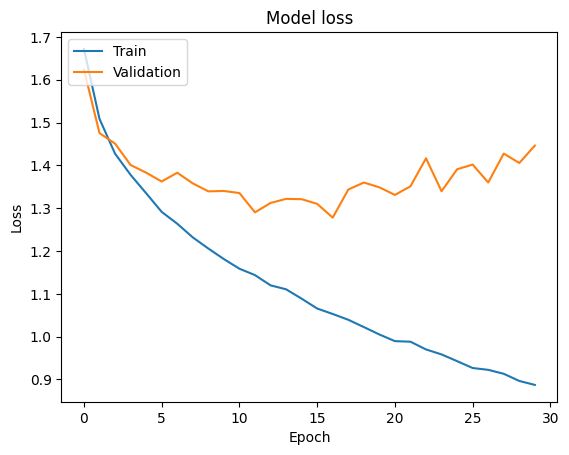

In [20]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy:', accuracy)

# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy']) # history variable is now accessible
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

721/721 ━━━━━━━━━━━━━━━━━━━━ 96s 133ms/step


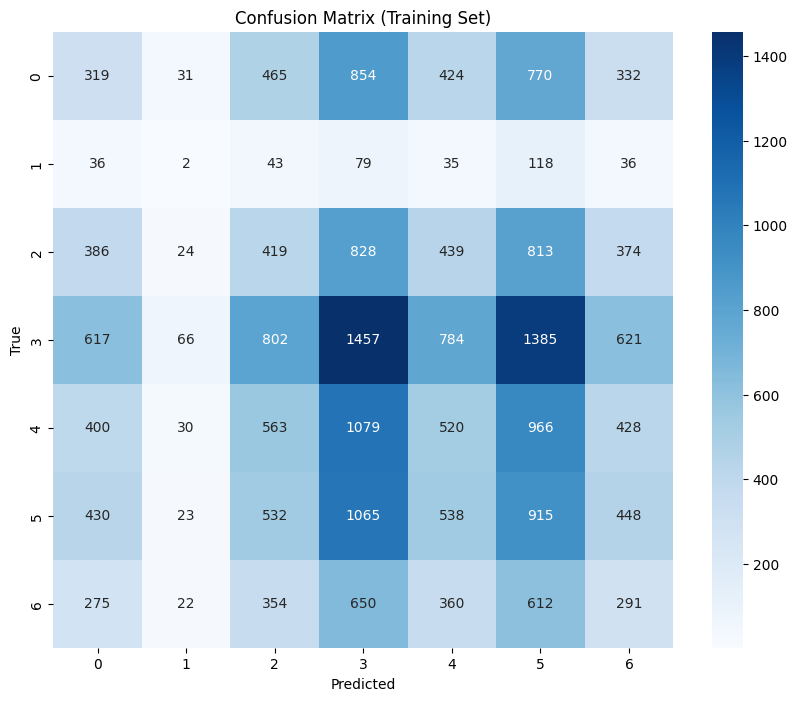

In [55]:
# prompt: Now i need a confusion matrix for both predicted and train data

# Get predictions for the training set
Y_pred_train = model.predict(train_generator)
y_pred_train = np.argmax(Y_pred_train, axis=1)

# Get true labels for the training set
Y_true_train = train_generator.classes

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(Y_true_train, y_pred_train)

# Plot the confusion matrix for the training set
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training Set)')
plt.show()

In [56]:
# prompt: /content/face-expression-recognition-dataset/images/validation/fear/9040.jpg  hw i can test this image

from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/face-expression-recognition-dataset/images/validation'  # Replace with the actual path to your image

img = image.load_img('/content/face-expression-recognition-dataset/images/validation/fear', target_size=(64, 64))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the image

# Predict the class of the image
prediction = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(prediction)

# You can map the predicted_class to the corresponding emotion label
# (e.g., 0: 'Angry', 1: 'Disgust', 2: 'Fear', etc.)

print('Predicted class:', predicted_class)
#print('Predicted emotion:', emotion_labels[predicted_class])

IsADirectoryError: [Errno 21] Is a directory: '/content/face-expression-recognition-dataset/images/validation/fear'

In [35]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Step 1: Load the saved model
model = load_model('/content/my_model.h5')  # Replace with your actual model file path










In [39]:
# Step 2: Load and preprocess the new image
def preprocess_image(img_path):
    # Resize to the input size expected by your model (64, 64)
    img = image.load_img('/content/face-expression-recognition-dataset/images/validation/happy/10019.jpg', target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match input shape (1, height, width, channels)
    img_array = img_array / 255.0  # Normalize the image (assuming your model was trained with normalized data)
    return img_array

In [37]:
# Load your test image
img_path = '/content/face-expression-recognition-dataset/images/validation'  # Replace with your test image path
test_img = preprocess_image('/content/face-expression-recognition-dataset/images/validation')

In [46]:
# Step 3: Predict on the image
# Replace with the actual path to your image
image_path = '/content/face-expression-recognition-dataset/images/validation'

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Make prediction
predictions = model.predict(preprocessed_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [47]:
# Step 4: Interpret the result
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']  # Your class labels
predicted_label = class_labels[predicted_class[0]]

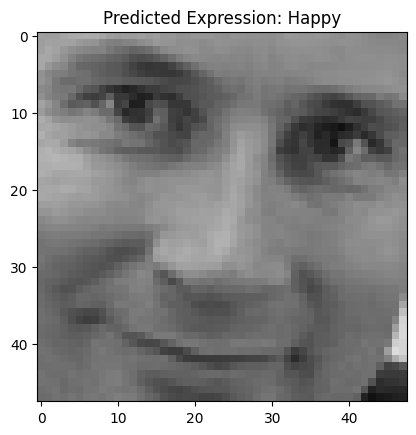

Predicted Expression: Happy


In [42]:
# Display the image and the prediction
img = image.load_img('/content/face-expression-recognition-dataset/images/validation/happy/10019.jpg')
plt.imshow(img)
plt.title(f'Predicted Expression: {predicted_label}')
plt.show()

print(f'Predicted Expression: {predicted_label}')

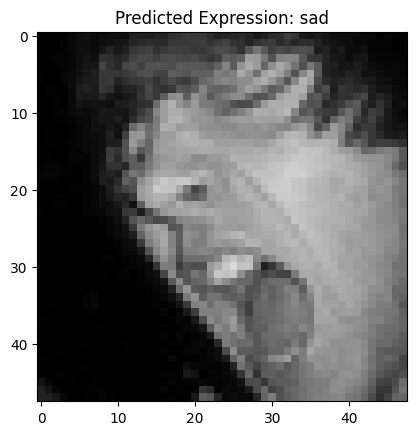

Predicted Expression: sad


In [64]:

# Display the image and the prediction
img = image.load_img('/content/face-expression-recognition-dataset/images/validation/sad/10004.jpg')
plt.imshow(img)
plt.title(f'Predicted Expression: {"sad"}')
plt.show()

print(f'Predicted Expression: {"sad"}')

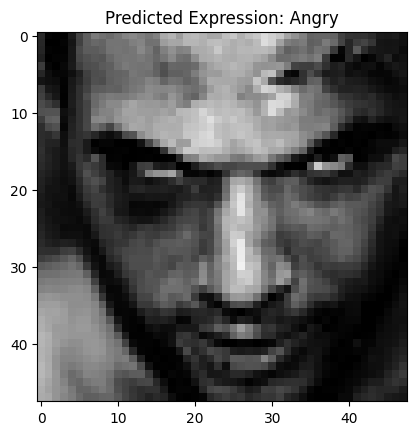

Predicted Expression: Angry


In [63]:
# Display the image and the prediction
# Display the image and the prediction
img = image.load_img('/content/face-expression-recognition-dataset/images/validation/angry/10215.jpg')
plt.imshow(img)
plt.title(f'Predicted Expression: {"Angry"}')
plt.show()


print(f'Predicted Expression: {"Angry"}')


In [65]:
# prompt: Now how i can check accuracy, f1 score and recall

from sklearn.metrics import classification_report

# ... (Your existing code) ...

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy:', accuracy)

# Get predictions for the validation set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
Y_true = validation_generator.classes

# Generate classification report
print(classification_report(Y_true, y_pred, target_names=validation_generator.class_indices.keys()))

45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.5017 - loss: 1.4050 
Validation accuracy: 0.5102763772010803
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step
              precision    recall  f1-score   support

       angry       0.15      0.11      0.13       192
     disgust       0.00      0.00      0.00        22
        fear       0.20      0.19      0.19       203
       happy       0.24      0.25      0.24       365
     neutral       0.15      0.11      0.12       243
         sad       0.19      0.29      0.23       227
    surprise       0.11      0.10      0.10       159

    accuracy                           0.18      1411
   macro avg       0.15      0.15      0.15      1411
weighted avg       0.18      0.18      0.18      1411



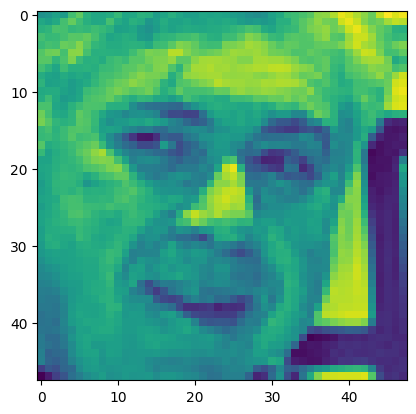

In [66]:
# prompt: waht would be the next code

# ... (Your existing code) ...

# Assuming 'validation_data.csv' exists and contains the image paths
validation_df = pd.read_csv('validation_data.csv')

# Get the path of the first image
first_validation_image_path = validation_df['image_path'].iloc[0]

# Display the first image
img = mpimg.imread(first_validation_image_path)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
# prompt: waht whould be the next line of code to complete this face recognition project

# Assuming 'validation_data.csv' exists and contains the image paths
validation_df = pd.read_csv('validation_data.csv')

# Get the path of the first image
first_validation_image_path = validation_df['image_path'].iloc[0]

# Display the first image
img = mpimg.imread(first_validation_image_path)
imgplot = plt.imshow(img)
plt.show()

In [67]:
# prompt: what will be after that line of code

# ... (Your existing code) ...

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy:', accuracy)

# Get predictions for the validation set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
Y_true = validation_generator.classes

# Generate classification report
print(classification_report(Y_true, y_pred, target_names=validation_generator.class_indices.keys()))

# ... (rest of your code)

45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.5316 - loss: 1.3705
Validation accuracy: 0.5145286917686462
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step
              precision    recall  f1-score   support

       angry       0.14      0.11      0.12       192
     disgust       0.00      0.00      0.00        22
        fear       0.16      0.15      0.16       203
       happy       0.25      0.25      0.25       365
     neutral       0.16      0.14      0.15       243
         sad       0.15      0.24      0.19       227
    surprise       0.10      0.09      0.10       159

    accuracy                           0.17      1411
   macro avg       0.14      0.14      0.14      1411
weighted avg       0.17      0.17      0.17      1411

